In [1]:
# import necessary libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Data - helper functions

def shuffle_data(data): 
    
    # shuffle data
    data = np.array(data)
    np.random.shuffle(data)
    
    return data

def process_data(file_path, train_val_split):
    
    # reads the file, shuffles the data randomly, splits into train 
    # and cross validation sets -> prints corresponding vector dimensions and returns X_train
    # y_train, X_val and y_val
    
    df_train = pd.read_csv(file_path)
    df_train = shuffle_data(df_train)

    train_size = round(df_train.shape[0] * train_val_split)
    data_train = df_train[:train_size,:].T
    data_val = df_train[train_size:,:].T
    print(f'data_train shape: {data_train.shape}')



    X_train = data_train[1:]
    y_train = data_train[0]
    X_val = data_val[1:]

    y_val = data_val[0]
    print(f'X_train shape:{X_train.shape}, \nY_train shape: {y_train.shape}')
    print(f'X_val shape:{X_val.shape}, \nY_val shape: {y_val.shape}')
    print('Data loading complete!')
    return X_train, y_train, X_val, y_val

def normalise_pixels(data):
    
    # divide each pixel by 255 to reduce value between 0 and 1
    return data / 255. 

def visualize_data(X_train,labels,START_IDX,END_IDX):
    IMG_SIZE = 28
    plt.figure(figsize=(5,5))
    for index in range(START_IDX,END_IDX):
        plt.subplot(4,4,1+index)
        plt.imshow(X_train[:,index].reshape(28,28), cmap = plt.cm.binary)
        plt.axis('off')
        plt.title(f'Label: {labels[index]}')
        plt.tight_layout()

def visualize_predicted_data(X_val, y_val, labels,START_IDX,END_IDX):
    IMG_SIZE = 28
    plt.figure(figsize=(8,8))
    for index in range(START_IDX,END_IDX):
        plt.subplot(4,4,1+index)
        plt.imshow(X_val[:,index].reshape(28,28), cmap = plt.cm.binary)
        plt.axis('off')
        plt.title(f'prediction: {labels[index]}')
        plt.tight_layout()

In [3]:
# Neural Network - helper functions

def init_params(layer_dims): 
    # initialise the weights and biases based on layers and return them 
    # as a dictionary
    params = {}
    for layer in range(1, len(layer_dims)): 
        params['W'+str(layer)] = np.random.randn(layer_dims[layer], layer_dims[layer-1]) * np.sqrt(1./layer_dims[layer])
        params['b'+str(layer)] = np.random.randn(layer_dims[layer],1) * np.sqrt(1./layer_dims[layer])
        
    return params

def relu(Z): 
    # compute RelU activation function
    return np.maximum(Z,0)

def softmax(Z):
    # compute softmax activation for output layer
    return np.exp(Z) / sum(np.exp(Z))

def relu_derivative(Z): 
    # compute derivative of ReLU 
    return Z>0

def derivative_softmax(Z): 
    # compute derivative of softmax
    return np.exp(Z) / sum(np.exp(Z)) * (1. - np.exp(Z) / sum(np.exp(Z)))

def one_hot_encoder(labels):

    # Y will be a (N, 1) vector where N is number of classes
    # locate the index of the Y label from the original Y vector
    # set it to 1
    # Output Y: [0,0,0,0,1,0,0,0,0].T
    
    Y_hot = np.zeros((labels.shape[0], labels.max()+1))
    Y_hot[np.arange(labels.shape[0]), labels] = 1
    Y_hot = Y_hot.T
    
    return Y_hot

def forward_propagation(X, params):
    
    # forward prop for neural network -> ReLU for L-1 layers, softmax for output layer
    # get number of layers from params, //2 since params return W,b for each layer
    
    layers = len(params) // 2 
    
    activations = {}
    activations['A0'] = X
    
    # input layer to layer L-1 (ReLU)
    
    for layer in range(1, layers): 
        activations['Z'+str(layer)] = np.dot(params['W'+str(layer)], activations['A'+str(layer-1)]) + params['b'+str(layer)]
        activations['A'+str(layer)] = relu(activations['Z'+str(layer)])
        
    # layer L -> softmax activation
    
    activations['Z'+str(layers)] = np.dot(params['W'+str(layers)], activations['A'+str(layers-1)]) + params['b'+str(layers)]
    activations['A'+str(layers)] = softmax(activations['Z'+str(layers)])
    
    return activations


def back_propagation(activations, params, Y):
    
    # Inputs:
    # activations: dictionary l {'A0':..., 'A1':..., 'Z1':..., 'A2':..., ...}
    # params: dictionary {'W1':..., 'b1':..., 'W2':...}
    # Y
    # Output: grads dictionary {'dW1':..., 'db1':..., ...}
      
        
        
  
    L = len(params) // 2  
    one_hot_Y = one_hot_encoder(Y)  
    m = one_hot_Y.shape[1]
  
    derivatives = {}
    grads = {}
  
    #  for layer L
    derivatives['dZ'+str(L)] = (activations['A'+str(L)] - one_hot_Y)
    grads['dW'+str(L)] = 1 / m * np.dot(derivatives['dZ'+str(L)], activations['A'+str(L-1)].T)
    grads['db'+str(L)] = 1 / m * np.sum(derivatives['dZ'+str(L)])
   
    # for layers L-1 to 1
    for l in reversed(range(1, L)):
        derivatives['dZ'+str(l)] = np.dot(params['W'+str(l+1)].T, derivatives['dZ'+str(l+1)]) * relu_derivative(activations['Z'+str(l)])
        grads['dW'+str(l)] = 1 / m * np.dot(derivatives['dZ'+str(l)], activations['A'+str(l-1)].T)
        grads['db'+str(l)] = 1 / m * np.sum(derivatives['dZ'+str(l)], axis=1, keepdims=True)
  
    return grads

def update_params(params, grads, alpha):
    layers = len(params) // 2
    
    updated_params = {}
    for layer in range(1, layers+1):
        updated_params['W'+str(layer)] = params['W'+str(layer)] - alpha*grads['dW'+str(layer)]
        updated_params['b'+str(layer)] = params['b'+str(layer)] - alpha*grads['db'+str(layer)]
    
    return updated_params

def cross_entropy(Y_one_hot, Y_hat, epsilon=1e-12):
    
    # clip predictions to avoid values of 0 and 1
    Y_hat = np.clip(Y_hat, epsilon, 1.-epsilon)
    
    # sum on the columns of Y_hat * np.log(Y), then take the mean 
    # between the m samples
    cross_entropy_loss = -np.mean(np.sum(Y_one_hot * np.log(Y_hat), axis=0))
    return cross_entropy_loss

def predictions(data): 
    # return max index by column
    return np.argmax(data, axis=0)

def get_accuracy(y_pred, y):
    
    return np.sum(y_pred == y) / y.size

In [27]:
# gradient descent optimizer - helper function

def gradient_descent(X, Y, layers_size, iterations, learning_rate): 
    
    params = init_params(layers_size)
    
    layers = len(params)//2
    accuracies = []
    losses = []
    
    # the training loop
    for iteration in range(1, iterations+1):
        activations = forward_propagation(X, params)
        
        Y_pred = predictions(activations['A'+str(layers)])
        accuracy = get_accuracy(Y_pred, Y)
        accuracies.append(accuracy)
        
        loss = cross_entropy(one_hot_encoder(Y), activations['A'+str(layers)])
        losses.append(loss)
        
        grads = back_propagation(activations, params, Y)
        params = update_params(params, grads, learning_rate)
        
        # print loss / accuracy every 10th iteration
        if iteration % 10 == 0:
            print(f'accuracy at iteration {iteration}: {accuracy}\nmodel loss: {loss}\n')
    
    # plot the loss / accuracy graphs
    plt.plot(range(1, iterations+1), accuracies, '-', color=sns.color_palette('deep')[0], linewidth=2, label='Training Accuracy')
    plt.plot(range(1, iterations+1), losses, ':', color=sns.color_palette('deep')[2], linewidth=2, label='Training Loss')
    plt.title("Network's Architecture: {}".format(layers_size))
    plt.legend(loc='upper right')
    plt.ylabel('loss/accuracy')
    plt.xlabel('Iterations')
    
    return params


def test_accuracy(X_val, y_val, trained_params):
    
    layers = len(trained_params) // 2
    start_index = 0
    end_index = 16
    
    # pass the X features through the neural network with the trained weights/biases
    activations = forward_propagation(X_val, trained_params)
    y_predictions = predictions(activations['A'+str(layers)])
    
    # plot X_val image alongside their predicted labels
    visualize_predicted_data(X_val, y_val, y_predictions, start_index, end_index)
    accuracy = get_accuracy(y_predictions, y_val)
    
    return accuracy



data_train shape: (785, 33600)
X_train shape:(784, 33600), 
Y_train shape: (33600,)
X_val shape:(784, 8400), 
Y_val shape: (8400,)
Data loading complete!


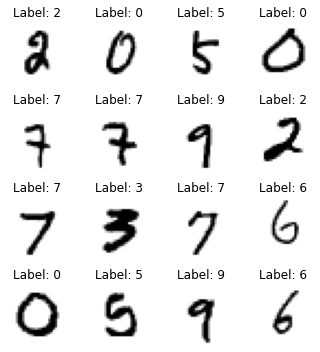

In [5]:
# Load, process and visualize the data - MNIST

X_train, y_train, X_val, y_val = process_data('train.csv', 0.8)
visualize_data(X_train,y_train,START_IDX=0,END_IDX=16)

# normalize training and val sets
X_train = normalise_pixels(X_train)
X_val = normalise_pixels(X_val)


In [6]:
# set network and optimizer parameters  

layer_architecture = [[784, 256, 128, 64, 10], 
                      [784, 128, 32, 10],
                      [784, 128, 10],
                      [784, 32, 10]]
iterations = 150
learning_rate = 0.1

accuracy at iteration 10: 0.6012202380952381
model loss: 1.4977671080277173

accuracy at iteration 20: 0.7094642857142858
model loss: 1.0556471056471637

accuracy at iteration 30: 0.7930357142857143
model loss: 0.7118276908561734

accuracy at iteration 40: 0.8011309523809523
model loss: 0.6259888042217848

accuracy at iteration 50: 0.8639880952380953
model loss: 0.4714189987509369

accuracy at iteration 60: 0.8801190476190476
model loss: 0.42185517937669786

accuracy at iteration 70: 0.8883333333333333
model loss: 0.3929141515739325

accuracy at iteration 80: 0.8936309523809524
model loss: 0.3686612302054574

accuracy at iteration 90: 0.9082440476190476
model loss: 0.32401268244254594

accuracy at iteration 100: 0.913422619047619
model loss: 0.30622782140475235

accuracy at iteration 110: 0.9161011904761904
model loss: 0.29574422364053926

accuracy at iteration 120: 0.91875
model loss: 0.28622213078790104

accuracy at iteration 130: 0.9233333333333333
model loss: 0.27127753695325096

a

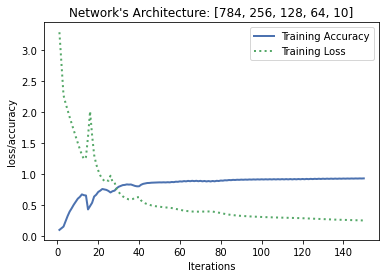

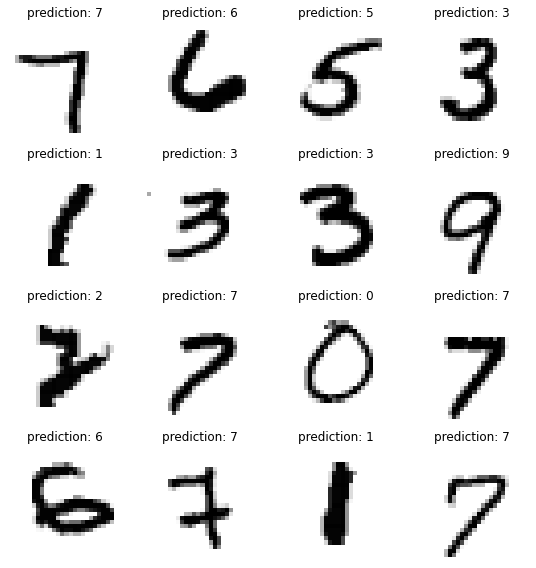

In [14]:
trained_params = gradient_descent(X_train, y_train, layer_architecture[0], iterations, learning_rate)
test_acc = test_accuracy(X_val, y_val, trained_params)
print(f'model test accuracy: {test_acc}')

accuracy at iteration 10: 0.564047619047619
model loss: 1.3844921665204246

accuracy at iteration 20: 0.7580059523809524
model loss: 0.8507083874882596

accuracy at iteration 30: 0.8119345238095238
model loss: 0.6529064931882461

accuracy at iteration 40: 0.8423214285714286
model loss: 0.5544846805415689

accuracy at iteration 50: 0.8583928571428572
model loss: 0.495207175324074

accuracy at iteration 60: 0.8694047619047619
model loss: 0.4550196367622056

accuracy at iteration 70: 0.8771428571428571
model loss: 0.4255421704930414

accuracy at iteration 80: 0.8836309523809524
model loss: 0.40260205592751297

accuracy at iteration 90: 0.8880357142857143
model loss: 0.38405709870341187

accuracy at iteration 100: 0.8925892857142858
model loss: 0.3686239306983509

accuracy at iteration 110: 0.8971428571428571
model loss: 0.3554549593725541

accuracy at iteration 120: 0.9000595238095238
model loss: 0.343940351159664

accuracy at iteration 130: 0.9026785714285714
model loss: 0.33376141632273

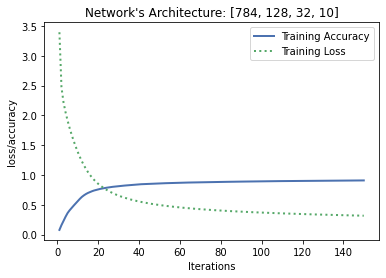

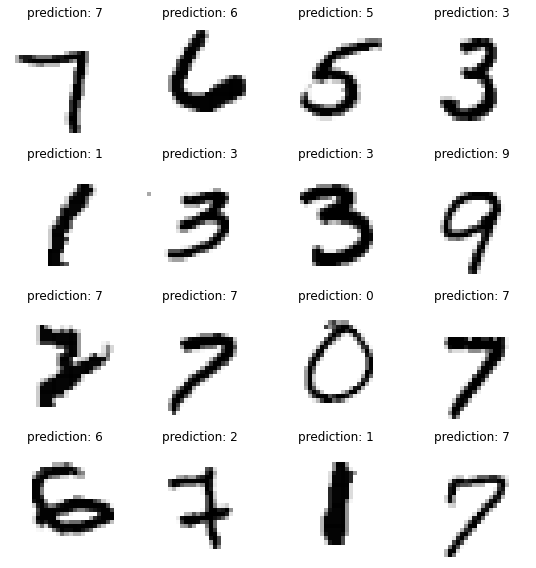

In [8]:
trained_params = gradient_descent(X_train, y_train, layer_architecture[1], iterations, learning_rate)
test_acc = test_accuracy(X_val, y_val, trained_params)
print(f'model test accuracy: {test_acc}')

accuracy at iteration 10: 0.6872321428571428
model loss: 0.9835755012419019

accuracy at iteration 20: 0.7966369047619047
model loss: 0.6777382391388522

accuracy at iteration 30: 0.8340773809523809
model loss: 0.5625740823253096

accuracy at iteration 40: 0.8548511904761905
model loss: 0.4992176049525838

accuracy at iteration 50: 0.8664880952380952
model loss: 0.4580059831390176

accuracy at iteration 60: 0.8760416666666667
model loss: 0.4284555230547162

accuracy at iteration 70: 0.8823809523809524
model loss: 0.40579751895531907

accuracy at iteration 80: 0.8879761904761905
model loss: 0.38763948685751043

accuracy at iteration 90: 0.8926488095238095
model loss: 0.37264208194667403

accuracy at iteration 100: 0.8965178571428571
model loss: 0.359928389801935

accuracy at iteration 110: 0.9000595238095238
model loss: 0.34893586283470096

accuracy at iteration 120: 0.9029166666666667
model loss: 0.3392563394051918

accuracy at iteration 130: 0.905327380952381
model loss: 0.33063072176

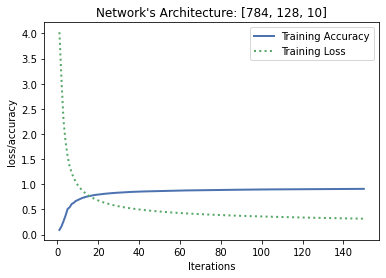

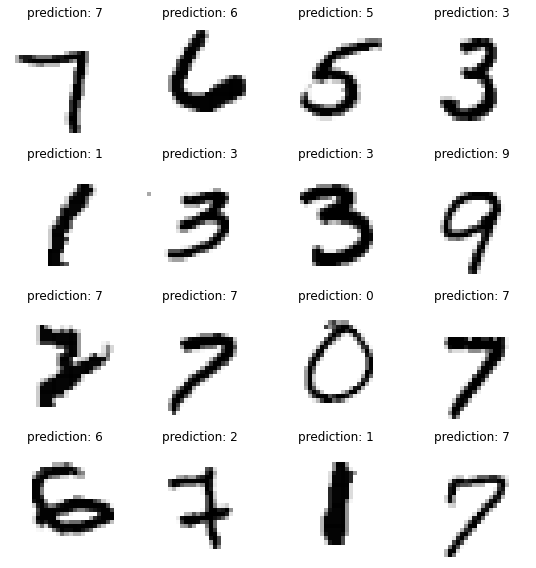

In [9]:
trained_params = gradient_descent(X_train, y_train, layer_architecture[2], iterations, learning_rate)
test_acc = test_accuracy(X_val, y_val, trained_params)
print(f'model test accuracy: {test_acc}')

accuracy at iteration 10: 0.31836309523809525
model loss: 1.9689715478558918

accuracy at iteration 20: 0.5061607142857143
model loss: 1.4820627772892927

accuracy at iteration 30: 0.6125595238095238
model loss: 1.1896547433136808

accuracy at iteration 40: 0.6781547619047619
model loss: 1.0060015186389275

accuracy at iteration 50: 0.7206547619047619
model loss: 0.8846757282346431

accuracy at iteration 60: 0.7480357142857142
model loss: 0.799866051525993

accuracy at iteration 70: 0.7702083333333334
model loss: 0.7376264280593673

accuracy at iteration 80: 0.7869940476190476
model loss: 0.6899592468188103

accuracy at iteration 90: 0.7985714285714286
model loss: 0.6520258357344734

accuracy at iteration 100: 0.8073809523809524
model loss: 0.6210016434206016

accuracy at iteration 110: 0.8157440476190476
model loss: 0.5950310647981375

accuracy at iteration 120: 0.8238690476190477
model loss: 0.5728843610604941

accuracy at iteration 130: 0.8300892857142858
model loss: 0.5536994041110

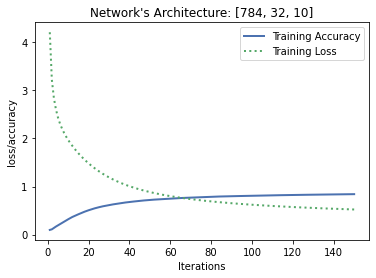

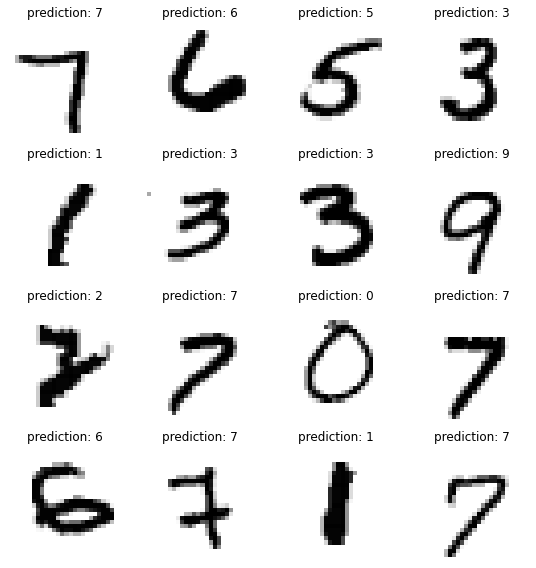

In [10]:
trained_params = gradient_descent(X_train, y_train, layer_architecture[3], iterations, learning_rate)
test_acc = test_accuracy(X_val, y_val, trained_params)
print(f'model test accuracy: {test_acc}')

In [41]:
# Test file predictions, attached csv file with submission
# saved as test_predictions, format like imageId, predictions
# trained_params from best performing model - ie first model with architecture [784, 256, 128, 64, 10]

def test_model(X, trained_params): 
    
    layers = len(trained_params) // 2
    activations = forward_propagation(X, trained_params)
    Y_predictions = pd.Series(predictions(activations['A'+str(layers)]))
    image_id = pd.Series(np.arange(1,len(X.T)+1))
    
    
    test_file_preds = pd.concat([image_id,Y_predictions],axis=1)
    test_file_preds.columns = ('imageId','Predictions')
    test_file_preds.to_csv('test_predictions', index=False)
    print(test_file_preds)



test_data = pd.read_csv('test.csv')
X_test = normalise_pixels(test_data.T)
test_model(X_test, trained_params)

       imageId  Predictions
0            1            2
1            2            0
2            3            9
3            4            9
4            5            3
...        ...          ...
27995    27996            9
27996    27997            7
27997    27998            3
27998    27999            9
27999    28000            2

[28000 rows x 2 columns]
